In [ ]:
%env LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
%env LLM_API_KEY=sk-替换为自己的Qwen API_KEY

In [2]:
%%capture --no-stderr
!pip install -U langchain langchain_community langchain_openai pypdf sentence_transformers chromadb shutil

In [3]:
import os
import pandas as pd

In [4]:
expr_version = 'split_01_5_markdown_header_text_split_v4'

preprocess_output_dir = os.path.join(os.path.pardir, 'outputs', 'v1_20240713')
expr_dir = os.path.join(os.path.pardir, 'experiments', expr_version)

os.makedirs(expr_dir, exist_ok=True)

# 读取文档

In [5]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(os.path.join(os.path.pardir, 'data', '2024全球经济金融展望报告.pdf'))

pdf_documents = loader.load()
markdown_documents = open(os.path.join(os.path.pardir, 'outputs', 'MinerU_parsed_20241204', '2024全球经济金融展望报告.md')).read()

qa_df = pd.read_excel(os.path.join(preprocess_output_dir, 'question_answer.xlsx'))

# 文档切分

In [6]:
import os
import pickle
from langchain.text_splitter import MarkdownHeaderTextSplitter, RecursiveCharacterTextSplitter
from uuid import uuid4

def split_pdf_docs(documents, filepath, chunk_size=400, chunk_overlap=40, seperators=['\n\n\n', '\n\n'], force_split=False):
    if os.path.exists(filepath) and not force_split:
        print('found cache, restoring...')
        return pickle.load(open(filepath, 'rb'))

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=seperators
    )
    split_docs = splitter.split_documents(documents)
    for chunk in split_docs:
        chunk.metadata['uuid'] = str(uuid4())

    pickle.dump(split_docs, open(filepath, 'wb'))

    return split_docs

def split_md_docs(markdown_document):
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
        ("###", "Header 3"),
    ]
    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on, strip_headers=False)
    md_header_splits = markdown_splitter.split_text(markdown_document)

    return md_header_splits

In [7]:
pdf_splitted_docs = split_pdf_docs(pdf_documents, os.path.join(preprocess_output_dir, 'split_docs.pkl'), chunk_size=500, chunk_overlap=50)
md_splitted_docs = split_md_docs(markdown_documents)

found cache, restoring...


In [8]:
len(pdf_splitted_docs)

52

In [9]:
pdf_splitted_docs[:3]

[Document(page_content='研究院\n全球经济金融展望报告\n要点2024年年报（总第57期） 报告日期：2023年12月12日\n●2023年全球经济增长动力持续回落，各国复苏分化，\n发达经济体增速明显放缓，新兴经济体整体表现稳定。\n全球贸易增长乏力，各国生产景气度逐渐回落，内需\n对经济的拉动作用减弱。欧美央行货币政策紧缩态势\n放缓，美元指数高位震荡后走弱，全球股市表现总体\n好于预期，但区域分化明显。高利率环境抑制债券融\n资需求，债券违约风险持续上升。\n●展望2024年，预计全球经济复苏将依旧疲软，主要\n经济体增长态势和货币政策走势将进一步分化。欧美\n央行大概率结束本轮紧缩货币周期，美元指数将逐步\n走弱，流向新兴经济体的跨境资本将增加。国际原油\n市场短缺格局或延续，新能源发展成为重点。\n●海湾六国经济发展与投资前景、高利率和高债务对\n美国房地产市场脆弱性的影响等热点问题值得关注。中国银行研究院\n全球经济金融研究课题组\n组长：陈卫东\n副组长：钟红\n廖淑萍\n成员：边卫红\n熊启跃\n王有鑫\n曹鸿宇\n李颖婷\n王宁远\n初晓\n章凯莉\n黄小军（纽约）\n陆晓明（纽约）\n黄承煜（纽约）\n宋达志（伦敦）\n李振龙（伦敦）\n张传捷（伦敦）\n刘冰彦（法兰克福）\n温颍坤（法兰克福）\n张明捷（法兰克福）\n王哲（东京）\n李彧（香港）\n黎永康（香港）\n联系人：王有鑫\n电话：010-66594127\n邮件：wangyouxin_hq@bank-of-china.com主要经济体GDP增速变化趋势（%）\n资料来源：IMF，中国银行研究院', metadata={'source': 'data/2024全球经济金融展望报告.pdf', 'page': 0, 'uuid': 'e73a0c9d-d42b-4350-a4c3-b38bf67c68a5'}),
 Document(page_content='全球经济金融展望报告\n中国银行研究院 1 2024年\n全球经济复苏疲软，货币政策取向分化\n——中国银行全球经济金融展望报告（2024年）\n2023年，全球经济增长动力持续回落。分区域看，各国复苏存在较大差异，\n发达经济体增速明显放缓，新兴经济体增速与2022年大致持平。生产端，全球\n供应链持续恢

In [10]:
len(md_splitted_docs)

47

In [11]:
md_splitted_docs[:3]

[Document(metadata={'Header 1': '全球经济金融展望报告'}, page_content='# 全球经济金融展望报告  \n2024年年报（总第57期）  \n报告日期：2023年12月12日'),
 Document(metadata={'Header 1': '要点'}, page_content='# 要点  \n●2023 年全球经济增长动力持续回落，各国复苏分化，发达经济体增速明显放缓，新兴经济体整体表现稳定。全球贸易增长乏力，各国生产景气度逐渐回落，内需对经济的拉动作用减弱。欧美央行货币政策紧缩态势放缓，美元指数高位震荡后走弱，全球股市表现总体好于预期，但区域分化明显。高利率环境抑制债券融资需求，债券违约风险持续上升。  \n$\\bullet$ 展望2024 年，预计全球经济复苏将依旧疲软，主要经济体增长态势和货币政策走势将进一步分化。欧美央行大概率结束本轮紧缩货币周期，美元指数将逐步走弱，流向新兴经济体的跨境资本将增加。国际原油市场短缺格局或延续，新能源发展成为重点。  \n$\\bullet$ 海湾六国经济发展与投资前景、高利率和高债务对美国房地产市场脆弱性的影响等热点问题值得关注。  \n![](images/c7e6ce1606712e84e07a05bcf6016906efa3fc778e40fcd0e91ac4fcb5503b79.jpg)\n主要经济体GDP 增速变化趋势（%）\n资料来源：IMF，中国银行研究院'),
 Document(metadata={'Header 1': '中国银行研究院全球经济金融研究课题组'}, page_content='# 中国银行研究院全球经济金融研究课题组  \n![](images/a5d0eb181c75231451c8f890ec50fe5822e2306a9beb543ca35a04880abbf639.jpg)  \n联系人：王有鑫\n电话：010-66594127\n邮件： wangyouxin_hq@bank-of-china.com')]

## 检查一下切分后的块长度分布

In [12]:
pd.Series([len(d.page_content) for d in pdf_splitted_docs]).describe()

count      52.000000
mean      623.307692
std       258.763920
min        65.000000
25%       476.750000
50%       618.000000
75%       801.250000
max      1306.000000
dtype: float64

In [13]:
pd.Series([len(d.page_content) for d in md_splitted_docs]).describe()

count      47.000000
mean      711.787234
std       677.696191
min         7.000000
25%       244.000000
50%       433.000000
75%      1040.500000
max      2862.000000
dtype: float64

## 检查超长块

In [14]:
for d in md_splitted_docs:
    if len(d.page_content) > 2000:
        print(d)
        break

page_content='# （一）全球经济将在波动分化中筑底复苏  
2023年，全球经济增长动力持续回落，经济增速连续两年下降。受地缘政治冲突、高通胀、货币政策紧缩等因素影响，全球经济下行压力加大。预计2023年全球GDP增速为 $2.7\%$ （市场汇率法），较2022年下降0.3个百分点。  
![](images/7600acb45b91442f8127f20629c791d91f04827835929cb12612c409fde82574.jpg)
图1：全球GDP增速 $(\%)$ ）  
资料来源：IMF，中国银行研究院  
分区域看，全球经济复苏不均衡，各国存在较大差异。发达经济体增速明显放缓，预计2023年增速较2022年下降1个百分点。其中，欧元区和英国经济增速大幅下降，美国表现好于其他发达经济体。2023年三季度，欧元区和英国GDP环比增速均由之前的正增长转为负增长，分别下降 $0.1\%$ 和 $0.03\%$ ；美国GDP环比增长折年率为 $4.9\%$ ，比二季度增速高2.8个百分点。新兴经济体增速与2022年大致持平，预计2023年增速比2022年下降0.1个百分点。其中，东南亚等出口型经济体增长承压，拉美、非洲等大宗商品出口国增速放缓，中东欧国家经济增速加快（图2）。  
![](images/abf30ccab508a0c4733d58e3810cda53dabdaeb4239acf37e57a931a0296d80c.jpg)
图2：主要经济体GDP增速变化趋势（%）
注：东盟五国包含印度尼西亚、马来西亚、菲律宾、新加坡和泰国。  
资料来源：IMF，中国银行研究院  
从生产端看，全球供应链持续恢复，但生产景气度逐渐回落。截至2023年10月底，纽约联储全球供应链压力指数降至有记录以来的最低值。荷兰经济分析局数据显示，全球工业生产量于4月触及年内低位，5-8月逐月回升，但发达经济体和新兴经济体分化明显（图3）。其中，主要新兴经济体工业生产指数普遍走高，如俄罗斯、土耳其、南非等，而发达经济体中的美国和韩国回升，英国、德国、意大利下行，日本波动较大，整体趋于平稳。全球融资环境收紧和经济下行压力对工业生产前景带来较大影响，全球制造业PMI指数明显回落，从2月的 $49.9\%$ 降至10月的 $48.8\%$ 。  
![](im

考虑到有不少切片依然非常大，此处对较大的片段做二次切分

In [15]:
from langchain.text_splitter import MarkdownTextSplitter

new_md_splitted_docs = []
splitter = MarkdownTextSplitter(
    chunk_size=500,
    chunk_overlap=50
)
for doc in md_splitted_docs:
    if len(doc.page_content) > 700:
        small_chunks = splitter.split_documents([doc])
        # 把原始文档的标题回小片段的正文
        for doc in small_chunks[1:]:
            header_prefix = ''
            for head_level in range(1, 4):
                if f'Header {head_level}' in doc.metadata:
                    header_prefix += '#' * head_level + ' ' + doc.metadata[f'Header {head_level}'] + '\n'
            doc.page_content = header_prefix + doc.page_content
        
        new_md_splitted_docs.extend(small_chunks)
    else:
        new_md_splitted_docs.append(doc)

In [16]:
len(new_md_splitted_docs)

102

# 检索

In [17]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores import Chroma
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

def get_embeddings(model_path):
    embeddings = HuggingFaceBgeEmbeddings(
        model_name=model_path,
        model_kwargs={'device': device},
        encode_kwargs={'normalize_embeddings': True},
        # show_progress=True
        query_instruction='为这个句子生成表示以用于检索相关文章：'
    )
    return embeddings

device: cuda


In [18]:
import shutil

from tqdm.auto import tqdm
from langchain_community.vectorstores import Chroma

model_path = 'BAAI/bge-large-zh-v1.5'
embeddings = get_embeddings(model_path)

def get_vector_db(splitted_docs, embeddings, name):
    persist_directory = os.path.join(expr_dir, 'chroma', 'bge', name)
    shutil.rmtree(persist_directory, ignore_errors=True)
    vector_db = Chroma.from_documents(
        splitted_docs,
        embedding=embeddings,
        persist_directory=persist_directory
    )
    return vector_db

使用新的切分方式，每个切片的UUID跟原始切片不一致了，检索的Ground Truth丢失了，此处通过向量检索的方式，将原始的UUID复制到Markdown的切片上，方便后续排查检索问题

In [19]:
pdf_vector_db = get_vector_db(pdf_splitted_docs, embeddings, 'pdf')

In [20]:
# 以新切片作为query，查询旧切片中最相似的那个，将它的UUID复制到新切片中
for doc in new_md_splitted_docs:
    query = doc.page_content
    # 只检索最相似的那个
    chunk_score_pair = pdf_vector_db.similarity_search_with_relevance_scores(query, k=1)[0]
    doc.metadata['uuid'] = chunk_score_pair[0].metadata['uuid']
    doc.metadata['pdf_chunk_sim'] = chunk_score_pair[1]

/tmp/ipykernel_1294088/1778381455.py:5: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'page': 46, 'source': 'data/2024全球经济金融展望报告.pdf', 'uuid': '873ee876-8549-49b9-b182-6584113b2701'}, page_content='全球经济金融展望报告\n中国银行研究院 45 2024年\n第四，中海深化经贸合作将为人民币国际化搭建新的平台。“石油美元”\n体系对于非美元国家能源贸易存在不同程度的制约。在该体系下，中东石油出\n口国需要在一定程度上放弃独立的货币政策，承担较大的汇率风险。尤其是近\n年来美元逐渐被“政治化”，各国对于贸易计价与结算货币多元化的需求不断\n增加。当前，中国与海湾六国拥有紧密的经贸联系，并且随着19个阿拉伯国家\n相继加入“一带一路”倡议，人民币使用场景不断拓宽，为人民币国际化创造\n了有利条件。未来，中海有望以双边经贸为依托，将人民币跨境贸易支付作为\n人民币在中东地区使用的主要切入点，扩展与海湾六国在人民币储备和投资等\n领域的货币合作，共同开发绿色金融，充分释放中海双方在推动人民币国际化\n上的合作潜力。\n专题二：高利率、高债务与美国房地产市场脆弱性\n近期，美联储考察了影响金融稳定的风险因素，商业和居住房地产风险的\n排名从2023年5月的第四位上升至10月的第二位，仅次于持续通胀与货币政\n策紧缩风险。美国房地产市场的演进路径及风险传染引发市场高度关注。\n（一）居住房地产市场\n2023年二季度，美国居住房地产市值余额为56.3万亿美元，不仅远大于商\n业房地产的24万亿美元，且在各类资产中排名第一。房地产在居民净资产中占\n比达30%，房贷在居民债务中占比达66%，该市场的走势对美国金融市场、经\n济走势影响巨大。鉴于该市场对利率及债务高度敏感，美联储加息及居民债务\n负担上升将增加金融脆弱性。2022年3月以来，美联储激进加息，30年期住房\n抵押贷款固定利率月均值从4%的历史低位逐渐上升至2023年10月的7.6%，远\n高于次贷危机发生之前的6.5%。与次贷危机相比，本轮货币紧缩周期中居住

chunk_score_pair的结构如下

In [21]:
chunk_score_pair

(Document(metadata={'page': 51, 'source': 'data/2024全球经济金融展望报告.pdf', 'uuid': 'ebf0d999-59f6-4fd3-941e-05a7a60c255a'}, page_content='免责声明\n本研究报告由中国银行研究院撰写，研究报告中所引用信息均来自公开资料。\n本研究报告中包含的观点或估计仅代表作者迄今为止的判断，它们不一定反映中国银行的观点。中国\n银行研究院可以不经通知加以改变，且没有对此报告更新、修正或修改的责任。\n本研究报告内容及观点仅供参考，不构成任何投资建议。对于本报告所提供信息所导致的任何直接的\n或者间接的投资盈亏后果不承担任何责任。\n本研究报告版权仅为中国银行研究院所有，未经书面许可，任何机构和个人不得以任何形式翻版、复\n制和发布。如引用发布，需注明出处为中国银行研究院，且不得对本报告进行有悖原意的引用、删节和修\n改。中国银行研究院保留对任何侵权行为和有悖报告原意的引用行为进行追究的权利。'),
 0.8652316217743071)

In [22]:
md_vector_db = get_vector_db(new_md_splitted_docs, embeddings, 'md')

# 计算检索准确率

In [23]:
test_df = qa_df[(qa_df['dataset'] == 'test') & (qa_df['qa_type'] == 'detailed')]

In [24]:
len(test_df)

93

In [25]:
def get_hit_stat_df(vector_db, top_k_arr=list(range(1, 9))):
    hit_stat_data = []

    for k in tqdm(top_k_arr):
        for idx, row in test_df.iterrows():
            question = row['question']
            true_uuid = row['uuid']
            # chunks = retrieve_fn(question, k=k)
            chunks = vector_db.similarity_search(question, k=k)
            retrieved_uuids = [doc.metadata['uuid'] for doc in chunks]

            hit_stat_data.append({
                'question': question,
                'top_k': k,
                'hit': int(true_uuid in retrieved_uuids),
                'retrieved_chunks': len(chunks)
            })
    hit_stat_df = pd.DataFrame(hit_stat_data)
    return hit_stat_df

In [26]:
hit_stat_df = get_hit_stat_df(md_vector_db)

  0%|          | 0/8 [00:00<?, ?it/s]

In [27]:
hit_stat_df.groupby(['top_k'])['hit'].mean().reset_index().rename(columns={'hit': 'hit_rate'})

,top_k,hit_rate
0,1,0.397849
1,2,0.483871
2,3,0.516129
3,4,0.602151
4,5,0.634409
5,6,0.677419
6,7,0.709677
7,8,0.731183


<Axes: xlabel='top_k', ylabel='hit'>

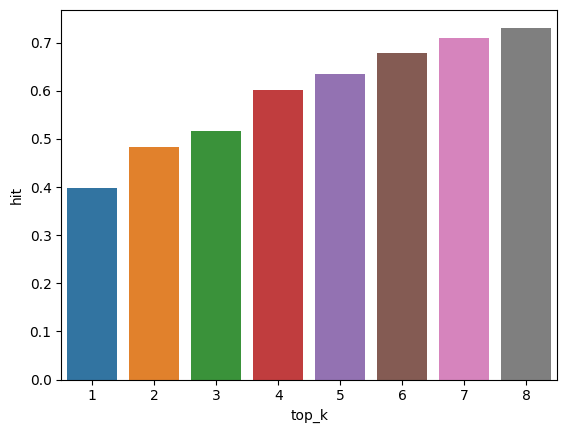

In [28]:
import seaborn as sns

sns.barplot(x='top_k', y='hit', data=hit_stat_df, errorbar=None)

# 生成答案

In [29]:
from langchain.llms import Ollama

ollama_llm = Ollama(
    model='qwen2:7b-instruct-32k',
    base_url='http://localhost:11434',
    top_k=1
)

/tmp/ipykernel_1294088/2053630348.py:3: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  ollama_llm = Ollama(


In [30]:
import time

def rag(vector_db, llm, query, n_chunks=4):
    prompt_tmpl = """
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{{knowledge}}
<<<</context>>>

问题：{{query}}
请回答：
""".strip()
    chunks = vector_db.similarity_search(query, k=n_chunks)
    prompt = prompt_tmpl.replace('{{knowledge}}', '\n\n'.join([doc.page_content for doc in chunks])).replace('{{query}}', query)
    retry_count = 3

    resp = ''
    while retry_count > 0:
        try:
            resp = llm.invoke(prompt)
            break
        except Exception as e:
            retry_count -= 1
            sleeping_seconds = 2 ** (4 - retry_count)
            print(f"query={query}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
            
            time.sleep(sleeping_seconds)
    
    return resp, chunks

## 预测

In [31]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']].rename(columns={'answer': 'ref_answer'})

def predict(vector_db, llm, prediction_df, n_chunks):
    prediction_df = prediction_df.copy()
    answer_dict = {}

    for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        uuid = row['uuid']
        question = row['question']
        answer, chunks = rag(vector_db, llm, question, n_chunks=n_chunks)
        assert len(chunks) <= n_chunks
        answer_dict[question] = {
            'uuid': uuid,
            'ref_answer': row['ref_answer'],
            'gen_answer': answer,
            'chunks': chunks
        }

    prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
    prediction_df.loc[:, 'chunks'] = prediction_df['question'].apply(lambda q: answer_dict[q]['chunks'])

    return prediction_df

In [32]:
save_path = os.path.join(expr_dir, 'predictions.pkl')

if os.path.exists(save_path):
    pred_dfs = pickle.load(open(save_path, 'rb'))
else:
    pred_dfs = {}

In [33]:
n_chunks_arr = range(3, 11)

for n_chunks in tqdm(n_chunks_arr):
    if n_chunks in pred_dfs:
        continue

    print(f"n_chunks={n_chunks}")
    pred_dfs[n_chunks] = predict(md_vector_db, ollama_llm, prediction_df, n_chunks=n_chunks)

  0%|          | 0/8 [00:00<?, ?it/s]

n_chunks=3


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=4


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=5


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=6


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=7


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=8


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=9


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=10


  0%|          | 0/100 [00:00<?, ?it/s]

In [34]:
pred_dfs.keys()

dict_keys([3, 4, 5, 6, 7, 8, 9, 10])

In [35]:
save_path = os.path.join(expr_dir, 'pred_dfs.pkl')

if not os.path.exists(save_path):
    print(f'saving to {save_path}')
    pickle.dump(pred_dfs, open(save_path, 'wb'))

# 评估

In [36]:
from langchain_openai import ChatOpenAI
import time

judge_llm = ChatOpenAI(
    api_key=os.environ['LLM_API_KEY'],
    base_url=os.environ['LLM_BASE_URL'],
    model_name='qwen2-72b-instruct',
    temperature=0
)

def evaluate(prediction_df):
    """
    对预测结果进行打分
    :param prediction_df: 预测结果，需要包含问题，参考答案，生成的答案，列名分别为question, ref_answer, gen_answer
    :return 打分模型原始返回结果
    """
    prompt_tmpl = """
你是一个经济学博士，现在我有一系列问题，有一个助手已经对这些问题进行了回答，你需要参照参考答案，评价这个助手的回答是否正确，仅回复“是”或“否”即可，不要带其他描述性内容或无关信息。
问题：
<question>
{{question}}
</question>

参考答案：
<ref_answer>
{{ref_answer}}
</ref_answer>

助手回答：
<gen_answer>
{{gen_answer}}
</gen_answer>
请评价：
    """
    results = []

    for _, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        question = row['question']
        ref_answer = row['ref_answer']
        gen_answer = row['gen_answer']

        prompt = prompt_tmpl.replace('{{question}}', question).replace('{{ref_answer}}', str(ref_answer)).replace('{{gen_answer}}', gen_answer).strip()
        
        retry_count = 3
        result = ''
        
        while retry_count > 0:
            try:
                result = judge_llm.invoke(prompt).content
                break
            except Exception as e:
                retry_count -= 1
                sleeping_seconds = 2 ** (4 - retry_count)
                print(f"query={question}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
                
                time.sleep(sleeping_seconds)
        
        results.append(result)

        time.sleep(1)
    return results

In [37]:
metrics = []

for n_chunks in tqdm(pred_dfs):
    pred_df = pred_dfs[n_chunks]
    pred_df['raw_score'] = evaluate(pred_df)
    pred_df['score'] = (pred_df['raw_score'] == '是').astype(int)
    print(f"n_chunks={n_chunks} raw_score unique: {pred_df['raw_score'].unique()}, accuracy={pred_df['score'].mean()}")

    metrics.append({
        'n_chunks': n_chunks,
        'accuracy': pred_df['score'].mean()
    })

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=3 raw_score unique: ['是' '否'], accuracy=0.71


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=4 raw_score unique: ['是' '否'], accuracy=0.74


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=5 raw_score unique: ['是' '否'
 '否\n\n注：由于问题中没有给出具体的年份，而参考答案和助手回答中给出了不同的时间点（一个没有年份，一个指定了2024年），因此无法判断助手的回答是否完全准确。但是，按照题目要求，我仅能回答“是”或“否”，所以我选择了“否”。如果需要更详细的解释，请忽略此注释。'], accuracy=0.74


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=6 raw_score unique: ['是' '否'], accuracy=0.76


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=7 raw_score unique: ['是' '否'], accuracy=0.77


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=8 raw_score unique: ['是' '否'], accuracy=0.78


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=9 raw_score unique: ['是' '否'], accuracy=0.77


  0%|          | 0/100 [00:00<?, ?it/s]

n_chunks=10 raw_score unique: ['是' '否'
 '否\n\n（注：虽然纽约联储全球供应链压力指数下降可能表明供应链状况改善，但这并不一定意味着全球供应链已经完全恢复，因此，“持续恢复”和“降至有记录以来的最低值”这两个表述并不等价。） \n\n但是，根据题目要求，我只应该回答“是”或“否”，所以我的回答是“否”。'], accuracy=0.78


In [38]:
metrics_df = pd.DataFrame(metrics)

In [39]:
metrics_df

,n_chunks,accuracy
0,3,0.71
1,4,0.74
2,5,0.74
3,6,0.76
4,7,0.77
5,8,0.78
6,9,0.77
7,10,0.78


<Axes: xlabel='n_chunks', ylabel='accuracy'>

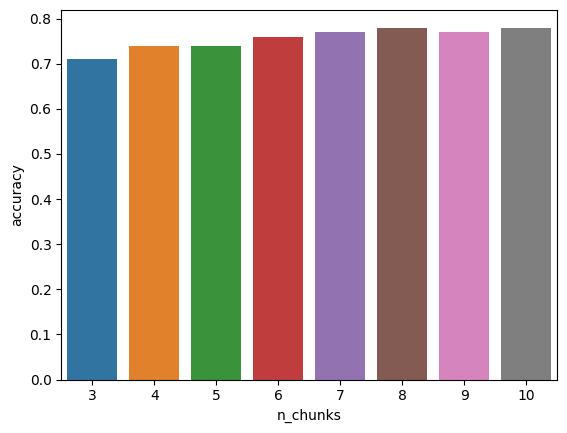

In [40]:
import seaborn as sns

sns.barplot(x='n_chunks', y='accuracy', data=metrics_df)

In [41]:
save_path = os.path.join(expr_dir, 'eval_dfs.pkl')

if not os.path.exists(save_path):
    print(f'saving to {save_path}')
    pickle.dump(pred_dfs, open(save_path, 'wb'))

saving to ../experiments/split_01_5_markdown_header_text_split_v4/eval_dfs.pkl
